## Output power prediction of Combined Cycle Power Plant Dataset using linear regression

The dataset for Combined Cycle Power Plant is available available at:

https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

### Importing libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve
from zipfile import ZipFile
from sklearn import preprocessing
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)

2.0.0-dev20190518
2.2.4-tf


### Downloadding data

We could use the browser to download CCPP.zip and decompress the file and extract the Folds5x2_pp.xlsx file, but it is preferable to have a few lines of code downloaded the required file.

In [2]:
from urllib.request import urlretrieve

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"

urlretrieve(url, "CCPP.zip")

('CCPP.zip', <http.client.HTTPMessage at 0x7f6620e2e828>)

### Extracting the .zip file

Following lines of code extract the file in specific location.

In [3]:
from zipfile import ZipFile 
  
file_name = "CCPP.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    zip.printdir()
    
    print("Extracting all the files now...") 
    zip.extractall("./dataset/") 
    print("Done!")

File Name                                             Modified             Size
CCPP/                                          2014-03-26 12:09:38            0
CCPP/Folds5x2_pp.ods                           2014-03-26 11:51:42      1723202
CCPP/Folds5x2_pp.xlsx                          2014-03-26 11:30:44      2029440
CCPP/Readme.txt                                2014-03-26 12:09:38         1793
CCPP/Readme.txt~                               2014-03-26 12:02:30         1738
Extracting all the files now...
Done!


### Importing the data using pandas library

We also detect the number of missing values in each coulmn (AT, V, AP, RH, and PE).

In [4]:
CCPP_raw_dataset = pd.read_excel("./dataset/CCPP/Folds5x2_pp.xlsx", sheet_name='Sheet1')

CCPP_pd = CCPP_raw_dataset.copy()

CCPP_pd.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

### Splitting the data to training and test datasets

We use pandas.sample to pick a random samples and also shuffle them.

In [5]:
CCPP_pd_train = CCPP_pd.sample(frac=0.9,random_state=0)
CCPP_pd_test = CCPP_pd.drop(CCPP_pd_train.index)

### Pairwise relationships in the dataset

As you see, we have a grid of plots. For example in row 2, the y-axis of all figures is variable "V" but x-axis is "AT", "V", "AP", "RH",and "PE" respectively. Second figure in that row shows the distribution of of the data for variable "V".

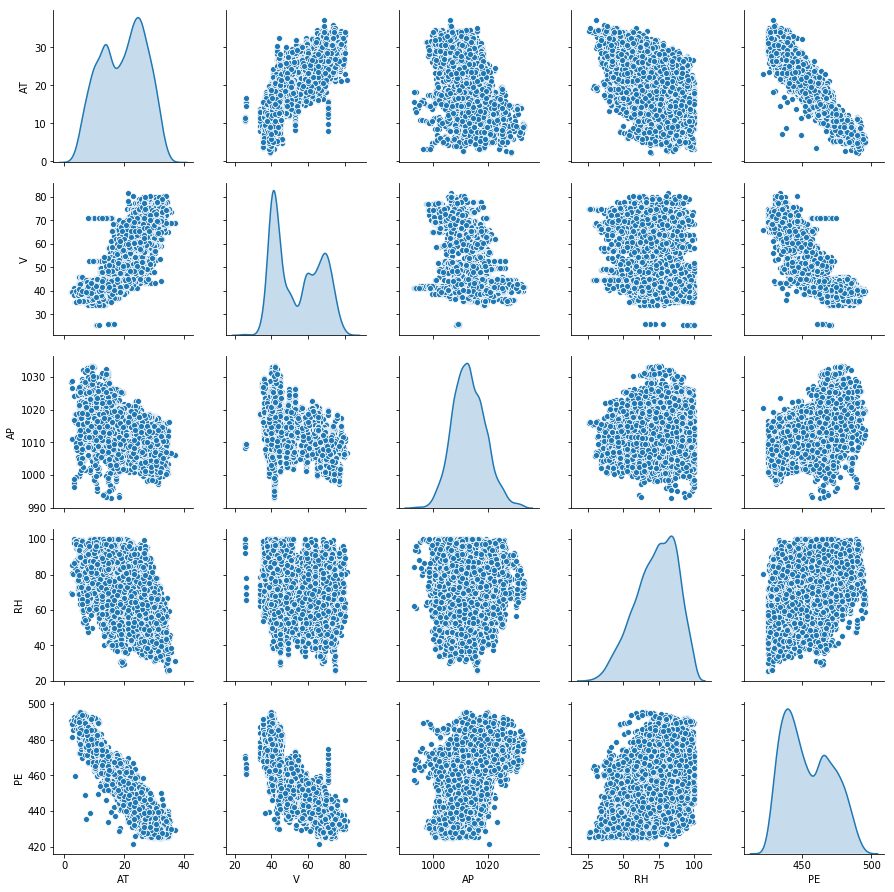

In [6]:
sns.pairplot(CCPP_pd_train[["AT", "V", "AP", "RH", "PE"]], diag_kind="kde")

### Statistics of the features

In [7]:
CCPP_pd_train_stats = CCPP_pd_train.describe()
CCPP_pd_train_stats.pop("PE")
CCPP_pd_train_stats = CCPP_pd_train_stats.transpose()
CCPP_pd_train_stats

,count,mean,std,min,25%,50%,75%,max
AT,8611.0,19.641649,7.442803,2.34,13.505,20.37,25.67,37.11
V,8611.0,54.310921,12.720553,25.36,41.700,52.08,66.54,81.56
AP,8611.0,1013.299128,5.952640,992.89,1009.150,1012.99,1017.29,1033.30
RH,8611.0,73.340246,14.587050,25.56,63.380,75.00,84.82,100.16


### Converting to NumPy arrays

We also change the data type while converting the data set.

In [8]:
CCPP_npy_train = CCPP_pd_train.to_numpy("float64")
CCPP_npy_test = CCPP_pd_test.to_numpy("float64")

### Standardizing the dataset

For more information check the following link:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [9]:
scaled_CCPP_npy_train = preprocessing.scale(CCPP_npy_train)
scaled_CCPP_npy_test = preprocessing.scale(CCPP_npy_test)

### Specifying features and labels of datasert

Features are inputs and lables are targets.

In [10]:
inputs_train = scaled_CCPP_npy_train[:,0:4]
targets_train = scaled_CCPP_npy_train[:,-1]

inputs_test = scaled_CCPP_npy_test[:,0:4]
targets_test = scaled_CCPP_npy_test[:,-1]

### Building the model

We build the model employing Keras Sequential mode.

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=[len(CCPP_pd_train.iloc[:, 0:4].keys())]),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    #tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=[len(CCPP_pd_train.iloc[:, 0:4].keys())]),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile (optimizer= optimizer, loss='mse', metrics = ['mae', 'mse'])

### General overview of the model

The summery method provides general overview of the model.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,701
Trainable params: 10,701
Non-trainable params: 0
_________________________________________________________________


### Verify whether the model is working.

In [13]:
example_batch = inputs_train[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.41039103],
       [ 0.02536909],
       [ 0.11164315],
       [ 0.08108138],
       [ 0.02981215],
       [ 0.4443064 ],
       [-0.02190273],
       [-0.01725245],
       [-0.0224511 ],
       [ 0.26686767]], dtype=float32)

### Training the model

Number of EPOCHS is chosen 1000.

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
    inputs_train, targets_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.088255,0.219390,0.088255,0.064732,0.199379,0.064732,0
1,0.062957,0.194009,0.062957,0.065380,0.204611,0.065380,1
2,0.061728,0.191557,0.061728,0.061285,0.195525,0.061285,2
3,0.060386,0.188938,0.060386,0.062331,0.200539,0.062331,3
4,0.059630,0.188293,0.059630,0.062273,0.198853,0.062273,4


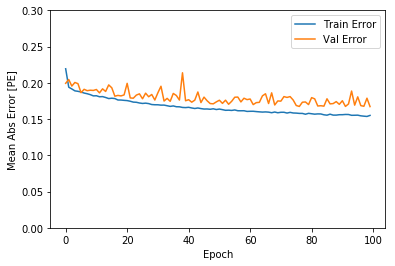

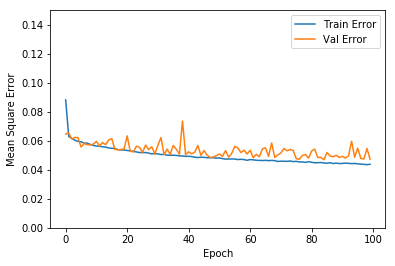

In [16]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [PE]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.15])
  plt.legend()
  plt.show()


plot_history(history)

### Early stopping

We use early stopping to avoid overfitting or there is no improvements in the results. 


..............................

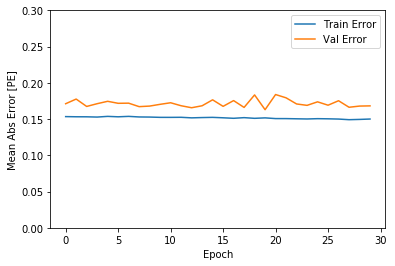

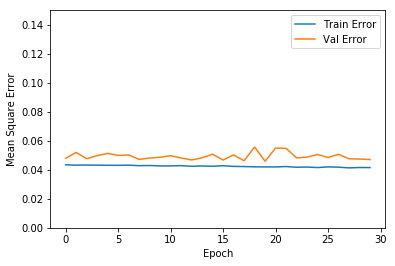

In [17]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(inputs_train, targets_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [18]:
loss, mae, mse = model.evaluate(inputs_test, targets_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} PE".format(mae))

Testing set Mean Abs Error:  0.18 PE


### Making predictions

It is performed using test dataset.

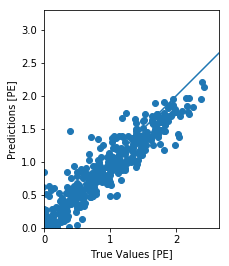

In [19]:
test_predictions = model.predict(inputs_test).flatten()
inputs_test.shape

plt.scatter(targets_test, test_predictions)
plt.xlabel('True Values [PE]')
plt.ylabel('Predictions [PE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

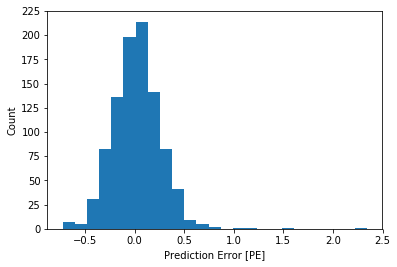

In [20]:
error = test_predictions - targets_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [PE]")
_ = plt.ylabel("Count")